### Create Synthetic Datasets
---

This notebook is used to generate simple sinusoidal synthetic datasets with a specified numbers of worms, named neurons, and other characteristics of real datasets.

**Last update:** _10 April 2024_

#### Libraries and helper functions
---

In [ ]:
import torch
import pickle
import random
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from typing import Union
from omegaconf import OmegaConf
from datasets import load_dataset
from scipy.integrate import odeint
from transformers import AutoTokenizer
from utils import NEURONS_302, init_random_seeds
from sklearn.preprocessing import StandardScaler
from tokenizers.pre_tokenizers import WhitespaceSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from preprocess._utils import CausalNormalizer, smooth_data_preprocess, reshape_calcium_data

# Initialize the random seeds
init_random_seeds(42)

### Helper functions
___

In [ ]:
def plot_neural_signals(data, time_tensor, neuron_idx=None, yax_limit=True, suptitle=None):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(0), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert neuron_idx <= num_neurons, "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert len(neuron_idx) <= num_neurons, "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15, num_columns))
    fig.tight_layout(pad=0.0)

    # If num_columns is 1, make ax iterable by wrapping it in a list
    if num_columns == 1:
        axs = [axs]

    # Now your existing loop should work without modification
    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("{}".format(NEURONS_302[column_indices[i]]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time (s)")

    # Add a super title to the figure if provided
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad=1)

    plt.show()

In [ ]:
def plot_3d_trajectory(X, axis_labels=("Time", "Value", "Z Axis"), title="Trajectory", show=True):
    """
    Plot a trajectory from a dataset, which can be 1D, 2D, or 3D.

    Parameters:
    - X: A 2D numpy array containing the trajectory data.
    - axis_labels: A tuple containing the labels for the axes. Default is ('Time', 'Value', 'Z Axis').
    - title: Title of the plot.
    - show: If True, the plot will be displayed. If False, the plot object will be returned.

    Returns:
    - fig, ax: The figure and axis objects of the plot if show is False.
    """
    max_timesteps = X.shape[0]
    dims = X.shape[1] if len(X.shape) > 1 else 1

    # Create a new figure for the plot
    fig = plt.figure()
    if dims >= 3:
        ax = fig.add_subplot(111, projection="3d")
        plot_dims = 3
    else:
        ax = fig.add_subplot(111)
        plot_dims = dims

    # Create a color map based on the time progression
    norm = plt.Normalize(0, max_timesteps)
    colors = plt.cm.viridis(norm(np.arange(max_timesteps)))

    # Extract coordinates from the data and plot accordingly
    if plot_dims == 1:
        x = np.arange(max_timesteps)
        y = X.flatten()
        z = np.zeros(max_timesteps)
        ax_labels = ("Time", axis_labels[0], "Fixed Z")
        # Plot the 1D trajectory with a color gradient
        for i in range(1, max_timesteps):
            ax.plot(x[i - 1 : i + 1], y[i - 1 : i + 1], color=colors[i], lw=0.5)
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], "ro", markersize=7)  # End with a red circle
    elif plot_dims == 2:
        x, y = X[:, 0], X[:, 1]
        z = np.zeros(max_timesteps)
        ax_labels = (axis_labels[0], axis_labels[1], "Fixed Z")
        # Plot the 2D trajectory
        for i in range(1, max_timesteps):
            ax.plot(x[i - 1 : i + 1], y[i - 1 : i + 1], color=colors[i], lw=0.5)
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], "ro", markersize=7)  # End with a red circle
    else:  # plot_dims == 3
        x, y, z = X[:, 0], X[:, 1], X[:, 2]
        ax_labels = axis_labels
        # Plot the 3D trajectory
        for i in range(1, max_timesteps):
            ax.plot(
                x[i - 1 : i + 1],
                y[i - 1 : i + 1],
                z[i - 1 : i + 1],
                color=colors[i],
                lw=0.5,
            )
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], z[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], z[-1], "ro", markersize=7)  # End with a red circle

    # Set labels for the axes
    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1])
    if plot_dims == 3:
        ax.set_zlabel(ax_labels[2])

    # Set title
    ax.set_title(title)

    # Show the plot
    if show:
        plt.show()
    else:
        return fig, ax

In [ ]:
def plot_autocorrelation_and_pacf(X, neurons):
    """
    Plot the autocorrelation and partial autocorrelation for each neuron's trajectory.

    Parameters:
    - X: A 2D numpy array of shape (max_timesteps, num_neurons) containing the neural trajectory data.
    - neurons: A list or array containing the neuron identifiers.

    Returns:
    - None: The function creates and displays a plot.
    """
    # Number of neurons
    num_neurons = X.shape[1]

    # Create a figure and an array of subplots with 2 columns
    fig, axes = plt.subplots(nrows=num_neurons, ncols=2, figsize=(10, 2 * num_neurons))

    # Set a suptitle for the entire figure
    fig.suptitle("Autocorrelation and Partial Autocorrelation for Neurons")

    # Iterate over the number of neurons to create individual plots
    for i in range(num_neurons):
        # Plot ACF on the left column (0th index)
        ax_left = axes[i, 0] if num_neurons > 1 else axes[0]
        plot_acf(X[:, i], ax=ax_left, use_vlines=False, marker="v", linestyle="--")
        ax_left.set_title(f"Neuron {neurons[i]} ACF")

        # Plot PACF on the right column (1st index)
        ax_right = axes[i, 1] if num_neurons > 1 else axes[1]
        plot_pacf(X[:, i], ax=ax_right, use_vlines=False, marker="*", linestyle="--")
        ax_right.set_title(f"Neuron {neurons[i]} PACF")
        ax_right.set_ylabel("")  # Clear the y-axis label to prevent clutter

        # Adjust y-axis limits so there is some white space around -1 and 1
        ax_left.set_ylim(-1.1, 1.1)
        ax_right.set_ylim(-1.1, 1.1)

        # Only the bottom plots need x-axis labels
        if i < num_neurons - 1:
            ax_left.set_xlabel("")
            ax_right.set_xlabel("")
        else:
            ax_left.set_xlabel("Lag")
            ax_right.set_xlabel("Lag")

    # Adjust the layout to not overlap plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plots
    plt.show()

In [ ]:
def time_delay_embedding(x, delay, dimension):
    """
    Constructs a time-delay embedding matrix from time series data.

    :param x: Time series data as a 1D numpy array.
    :param delay: The delay tau between time series elements in the embedding.
    :param dimension: The embedding dimension m.
    :return: The time-delay embedded data as a 2D numpy array.
    """
    n = len(x)
    if n < (dimension - 1) * delay + 1:
        raise ValueError("Time series data is too short for the given delay and dimension.")
    m = n - (dimension - 1) * delay
    embedded_data = np.empty((m, dimension))
    for i in range(m):
        for j in range(dimension):
            embedded_data[i, j] = x[i + j * delay]
    return embedded_data

In [ ]:
def lorenz(X, t, sigma=10.0, beta=8.0 / 3, rho=28.0):
    """The Lorenz equations."""
    x, y, z = X
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

In [ ]:
def van_der_pol_oscillator(X, t, mu=1.0):
    """The Van der Pol oscillator equations."""
    x, y = X
    dx_dt = y
    dy_dt = mu * (1 - x**2) * y - x
    return [dx_dt, dy_dt]

In [ ]:
class SinusoidsOscillator:
    def __init__(self, sum_freqs=0, random=True):
        self.eps = np.finfo(float).eps
        self.sum_freqs = sum_freqs
        self.random = random
        # create frequencies and phases
        if self.random:  # use random frequencies
            self.freqs = np.round(self.eps + np.random.random(self.sum_freqs) / 10, 4)
        else:  # use deterministic frequencies
            self.freqs = np.round(
                np.arange(1 / (2 * self.sum_freqs + self.eps), self.sum_freqs)
                / (10 * self.sum_freqs),
                4,
            )
        # always use random phases
        self.phases = np.random.random(self.sum_freqs) * 2 * np.pi

    def __call__(self, Y, t):
        y = Y
        dy_dt = -y + sum(np.cos(2 * np.pi * f * t + p) for f, p in zip(self.freqs, self.phases))
        return dy_dt


# create an instance of a SinusoidsOscillator dynamical system
sinusoids_oscillator = SinusoidsOscillator()

In [ ]:
def save_synthetic_dataset(file_name, dataset):
    with open(file_name, "wb") as f:
        pickle.dump(dataset, f)

In [ ]:
def calculate_spectral_radius(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    spectral_radius = max(abs(eigenvalues))
    return spectral_radius

In [ ]:
def adjust_matrix_to_edge_of_chaos(matrix, target_radius=1.0):
    # Calculate the current spectral radius
    current_radius = calculate_spectral_radius(matrix)
    
    # Calculate the gain needed to adjust the spectral radius to the target
    gain = target_radius / current_radius
    
    # Scale the matrix by the gain
    adjusted_matrix = matrix * gain
    
    return adjusted_matrix, gain

In [ ]:
def filter_rows_by_threshold(X, thresh):
    """
    Filters rows of matrix X where the absolute value of every element of the row is less than `thresh`.

    Parameters:
        X (np.ndarray): A numpy array of shape (t, n) where t is the number of time points
                        and n is the number of covariates.
        thresh (float): The threshold value to test against each element of the rows.

    Returns:
        np.ndarray: An array of row indices where the absolute value of each element in the row is less than `thresh`.
    """
    # Initialize a list to store the indices of rows that meet the condition
    selected_rows = []

    # Iterate over each row index
    for row in range(X.shape[0]):
        # Check if the absolute value of all elements in the row are less than `thresh`
        if np.all(np.abs(X[row, :]) < thresh):
            selected_rows.append(row)
    
    # Convert the list of indices to a numpy array
    return np.array(selected_rows)

# # Example usage:
# t, n = 5, 3  # 5 time points, 3 covariates
# X = np.array([[1, 2, 3],
#               [0.5, 0.5, -0.5],
#               [0.2, 0.1, 0.1],
#               [0.3, 1.9, 3.1],
#               [0.1, -0.2, -0.1]])

# thresh = 0.6
# filtered_indices = filter_rows_by_threshold(X, thresh)
# print("Filtered row indices:", filtered_indices)


#### Get default parameter values from configs

In [ ]:
config = OmegaConf.load("../configs/submodule/preprocess.yaml")
DELTA_T = config.preprocess.resample_dt

#### Wikitext dataset

In [ ]:
# TODO: Repurpose code from HuggingfaceTransformerDemo.ipynb
# def create_synthetic_dataset_wikitext(max_timesteps: int, tokenizer, dataset_name: str):
#     # Load the WikiText dataset
#     text_dataset = load_dataset("wikitext", "wikitext-103-raw-v1")

#     # Tokenize and chunk the dataset
#     text_dataset = text_dataset.map(
#         tokenize_and_chunk, batched=True, fn_kwargs=dict(tokenizer=tokenizer)
#     )

#     # Assume further processing and synthetic data generation as per your existing function

#     return text_dataset

# # Usage
# tokenizer = AutoTokenizer.from_pretrained("google/byt5-large")
# dataset = create_synthetic_dataset_wikitext(
#     max_timesteps=1500,
#     tokenizer=tokenizer,
#     dataset_name="WikiText0000"
# )


#### Shakespeare dataset

In [ ]:
def create_synthetic_dataset_shakespeare(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_named_neurons: Union[None, int] = None,
    tokenizer: Union[None, callable] = None,
    embedding_weight: Union[None, torch.Tensor] = None,
    smooth_method: Union[None, str] = "ES",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler(), #CausalNormalizer() #None
    dataset_name: str = "Shakespeare0000",
):
    # Load the Shakespeare dataset
    text_dataset = load_dataset("tiny_shakespeare")
    # Create a tokenizer
    if tokenizer is None:
        tokenizer = AutoTokenizer.from_pretrained("google/byt5-large")
    # Apply the tokenization and chunking to each split
    text_dataset = text_dataset.map(
        tokenize_and_chunk, batched=True, fn_kwargs=dict(tokenizer=tokenizer)
    )
    # Create an embedding table
    embedding_dim = num_signals
    assert isinstance(embedding_weight, torch.Tensor) and embedding_weight.shape == (
        tokenizer.vocab_size,
        embedding_dim,
    ), "embedding_weight must be a PyTorch tensor of shape (tokenizer.vocab_size, embedding_dim)"
    embedding = torch.nn.Embedding(
        num_embeddings=tokenizer.vocab_size,
        embedding_dim=embedding_dim,
        dtype=torch.half,
        _weight=embedding_weight,
        _freeze=True,
    )
    torch.nn.init.normal_(embedding.weight)
    # Extract all splits of the text dataset then concatenate them
    train_tokens = text_dataset["train"]["input_ids"]
    validation_tokens = text_dataset["validation"]["input_ids"]
    test_tokens = text_dataset["test"]["input_ids"]
    all_tokens = train_tokens + validation_tokens + test_tokens
    # Set up for creating the synthetic dataset
    if num_named_neurons is None or num_named_neurons > num_signals:  # default to all neurons
        num_named_neurons = num_signals
    elif num_named_neurons < 0:  # default to no neurons
        num_named_neurons = 0
    num_unknown_neurons = num_signals - num_named_neurons
    dataset = dict()
    # Create data for as many worms as possible
    worm_idx = 0
    calcium_data = []
    total_time = 0
    for chunk in all_tokens:
        if worm_idx > num_worms - 1:
            break
        embd_data = embedding(torch.LongTensor(chunk)).detach().numpy()
        calcium_data.append(embd_data)
        total_time += embd_data.shape[0]
        if total_time >= max_timesteps:
            calcium_data = np.vstack(calcium_data)
            if transform:
                calcium_data = transform.fit_transform(calcium_data)
            time_in_seconds = np.arange(total_time).reshape(-1, 1)
            dt = np.gradient(time_in_seconds, axis=0)
            dt[dt == 0] = np.finfo(float).eps
            resample_dt = np.round(np.median(dt).item(), 2)
            residual_calcium = np.gradient(calcium_data, axis=0) / dt
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data, time_in_seconds, smooth_method
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium, time_in_seconds, smooth_method
            )
            named_neuron_indices = random.sample(
                range(num_signals), num_named_neurons
            )  # without replacement
            named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)
            neuron_to_idx = {
                (neuron) if neuron in named_neurons else str(idx): idx
                for idx, neuron in enumerate(NEURONS_302) 
            }
            idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

            worm_data = dict()

            worm_data["worm"] = f"worm{worm_idx}"
            worm_data["source_dataset"] = dataset_name
            worm_data["smooth_method"] = smooth_method
            worm_data["calcium_data"] = calcium_data
            worm_data["smooth_calcium_data"] = smooth_calcium_data
            worm_data["residual_calcium"] = residual_calcium
            worm_data["smooth_residual_calcium"] = smooth_residual_calcium
            worm_data["max_timesteps"] = total_time
            worm_data["time_in_seconds"] = time_in_seconds
            worm_data["dt"] = dt
            worm_data["median_dt"] = resample_dt
            worm_data["neuron_to_idx"] = neuron_to_idx
            worm_data["idx_to_neuron"] = idx_to_neuron
            worm_data["num_neurons"] = num_signals
            worm_data["num_named_neurons"] = num_named_neurons
            worm_data["num_unknown_neurons"] = num_unknown_neurons

            worm_data = reshape_calcium_data(worm_data)
            dataset[f"worm{worm_idx}"] = worm_data

            worm_idx += 1
            calcium_data = []
            total_time = 0

    return dataset

In [ ]:
# Initialize parameters
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_named_neurons = 50  # None
tokenizer = AutoTokenizer.from_pretrained("google/byt5-large")  # None
embedding_weight = torch.randn(tokenizer.vocab_size, num_signals)  # None
smooth_method = None
transform = StandardScaler()
dataset_name = "Shakespeare0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_shakespeare(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_named_neurons=num_named_neurons,
    tokenizer=tokenizer,
    embedding_weight=embedding_weight,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Get the number of worms in the dataset
num_worms = len(dataset)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
num_worms = len(dataset)
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][:num_named_neurons]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

#### Recurrent Network dataset

Dynamics evolve according to

$$ \tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{M} f(\mathbf{x}) + \mathbf{b}, \tag{1} $$

where $\mathbf{M}$ is a set of random weights (chosen independently and identically from a Gaussian distribution with mean 0 and variance $\frac{g^2}{N}$).

We define $\alpha = \frac{\Delta t}{\tau}$. The discrete time update equation is given by

$$ \mathbf{x}(t + \Delta t) = \left(1 - \alpha\right) \mathbf{x}(t) + \alpha \mathbf{M} f(\mathbf{x}) + \mathbf{b} \Delta t$$

In [ ]:
def create_synthetic_dataset_recurrent(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_named_neurons: Union[None, int] = None,
    add_noise: bool = False,
    noise_std: float = 0.01,
    random_walk: bool = False,
    delta_seconds: float = DELTA_T,
    smooth_method: Union[None, str] = "ES",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler() #CausalNormalizer() #None
    dataset_name: str = "Recurrent0000",
):
    """
    Create a synthetic worm datasets using the Lorenz attractor.
    Three neurons are chosen randomly to represent x, y, z trajectories from the Lorenz system.

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param add_noise: Whether to add Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}
    # Define a fixed connectivity matrix ensuring that the network is connected 
    sparsity = 0.0
    connected = False
    while not connected:
        sparsity += 1/num_signals
        sparse_mask = np.random.choice([0, 1], size=(num_signals, num_signals), p=[1 - sparsity, sparsity])
        # Ensure there are autapse connection to ensure the connectivity matrix is full rank
        sparse_mask[np.diag_indices(num_signals)] = 1
        G = nx.from_numpy_array(sparse_mask)
        connected = nx.is_connected(G)
    connectivity_matrix = sparse_mask * np.random.randn(num_signals, num_signals)
    # Adjust the connectivity matrix to the edge of chaos
    # TODO: make target_radius an argument of the function
    target_radius = 1. 
    connectivity_matrix, _ = adjust_matrix_to_edge_of_chaos(connectivity_matrix, target_radius) 
    # Evolve the dynamics specified by the fixed connectivity and prespecified time constants
    alphas = np.ones(num_signals) # inverse time constants
    # Specify an input gain
    # TODO: make inp_gain an argument of the function
    inp_gain = 0.001 / np.sqrt(sparsity * num_signals) # DEBUG
    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # column vector
    # Calculate number of named and unknown neurons
    num_unknown_neurons = num_signals - num_named_neurons
    # Include some warmup timesteps to allow the system to reach a steady state
    warmup_timesteps = max_timesteps // 2
    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps + warmup_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)
        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302) 
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}
        # Create calcium data
        for t in range(max_timesteps + warmup_timesteps):
            # Initial conditions
            if t == 0:
                state = np.random.randn(num_signals) # initial values
                calcium_data[t] = state 
            # Evolve recurrent dynamics
            else: 
                inputs = np.random.randn(num_signals) * inp_gain  # i.i.d N(0,1) inputs
                state = (1 - alphas) * state + alphas * (connectivity_matrix @ np.tanh(state) + inputs)
                calcium_data[t] = state
        # Remove warmup timesteps
        calcium_data = calcium_data[warmup_timesteps:]
        # Add noise to the recorded neurons
        for neuron_index in named_neuron_indices:
            if add_noise:
                if random_walk:
                    noise_walk = np.cumsum(
                        [0]
                        + np.random.normal(
                            loc=0, scale=noise_std, size=max_timesteps - 1
                        ).tolist()
                    )
                    calcium_data[:, neuron_index] += noise_walk
                else:
                    noise_iid = np.random.normal(0, noise_std, max_timesteps)
                    calcium_data[:, neuron_index] += noise_iid
        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)
        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        # Smooth the data
        smooth_calcium_data = smooth_data_preprocess(calcium_data, time_in_seconds, smooth_method)
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )
        # Save the data
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons
        worm_data["extra_info"] = {
            "adjacency_matrix": sparse_mask,
            "inputs": inputs,
            "input_gain": inp_gain,
            "spectral_radius": target_radius,
            "sparsity": sparsity,
            "alphas": alphas,
            "connection_weights": connectivity_matrix,
            "meta_text": "`inputs` generated as iid N(0,1) noise multiplied by `input_gain`\n."
                        "adjacency_matrix` is binary.\n`connection_weights` has th edge strengths.\n"
                        "`spectral_radius` is the maximum absolute value of the eigenvalues of `connection_weights`.\n"
                        "`alphas` is a vector defined by alpha[i] dt/tau_i where tau is the time constant of the i-th neuron.\n",
        }
        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)
        # Save the data
        dataset[worm] = worm_data
    return dataset

In [41]:
# Initialize parameters
max_timesteps = 1500
num_worms = 10
num_signals = 302
num_named_neurons = 100
add_noise = False
noise_std = 0.1
random_walk = False
delta_seconds = DELTA_T
smooth_method = None
transform = StandardScaler()
dataset_name = "Recurrent0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_recurrent(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_named_neurons=num_named_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# # Save the dataset
# save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)


In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][:num_named_neurons]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

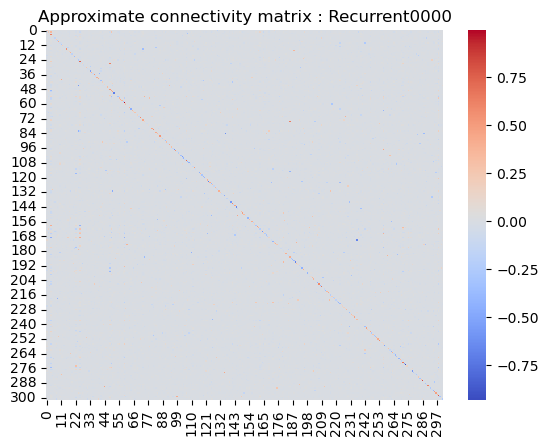

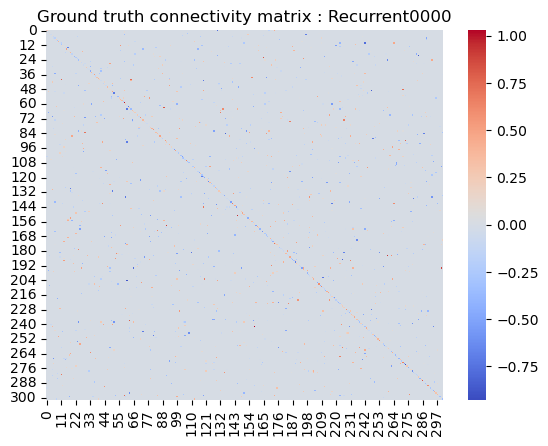

In [45]:
cov_X = np.zeros((num_signals, num_signals))
cov_X_fwd = np.zeros((num_signals, num_signals))
total_mask = np.zeros((num_signals, num_signals))
M = None
for idx in range(num_worms):
    # Get current worm ID
    worm_idx = f"worm{idx}"
    # Check that "connectome" is the same for all worms
    if M is None:
        M = dataset[worm_idx]["extra_info"]["connection_weights"]
        A = dataset[worm_idx]["extra_info"]["adjacency_matrix"]
    else:
        M_ = dataset[worm_idx]["extra_info"]["connection_weights"]
        assert np.allclose(M, M_), "Inconsisent connection weights!"
        M = M_
        A_ = dataset[worm_idx]["extra_info"]["adjacency_matrix"]
        assert np.allclose(A, A_), "Inconsistent adjacency matrix!"
        A = A_
    # Compute matrices needed to estimate the connectivity matrix
    mask = dataset[worm_idx]["named_neurons_mask"].numpy().reshape(1, -1)
    data = dataset[worm_idx]["calcium_data"].numpy()
    X = data 
    T = data.shape[0]
    S = mask.T @ mask
    total_mask += S
    cov_X +=  ( X[1:].T @ X[1:] ) / T * S
    cov_X_fwd += ( X[1:].T @ X[:-1] ) / T * S

    # ### DEBUG ###
    # print("data", data.shape)
    # inds = filter_rows_by_threshold(data * mask, thresh=3.)[:-1]
    # if len(inds) == 0:
    #     continue
    # print("len(inds)", len(inds))
    # S = mask.T @ mask
    # total_mask += S
    # cov_X +=  ( X[inds].T @ X[inds] ) * S
    # cov_X_fwd += ( X[inds + 1].T @ X[inds] ) * S
    # ### DEBUG ###
    
# total_mask = np.clip(total_mask, a_min=1, a_max=None)

# Average covariance matrix over repetitions of the same neuron across all worms
# NOTE: Dividing by num_worms is empirically better than dividing by total_mask
cov_X = cov_X/num_worms
cov_X_fwd = cov_X_fwd/num_worms
# cov_X = np.divide(cov_X, total_mask)
# cov_X_fwd = np.divide(cov_X_fwd, total_mask)

# Estimate of connectivity matrix
approx_M = cov_X_fwd @ np.linalg.pinv(cov_X)

# Plot figures
plt.figure()
ax = sns.heatmap(approx_M, cmap="coolwarm")#, xticklabels=NEURONS_302, yticklabels=NEURONS_302)
ax.set_title(f"Approximate connectivity matrix : {dataset_name}")
plt.show()

plt.figure()
ax = sns.heatmap(M, cmap="coolwarm")#, xticklabels=NEURONS_302, yticklabels=NEURONS_302)
ax.set_title(f"Ground truth connectivity matrix : {dataset_name}")
plt.show()

In [44]:
print("total_mask:", total_mask, end="\n\n")
print("num_worms:", num_worms)
print("cov_X rank:", np.linalg.matrix_rank(cov_X))
print("cov_X determinant", np.linalg.det(cov_X), end="\n\n")
print("estimate distance:", np.linalg.norm(M - approx_M, ord='fro'))
print("(distribution) chance distance:", np.linalg.norm(M - np.random.randn(*M.shape), ord='fro')) # if all you knew was that the weights were ~N(0,1)
print("(adjacency + distribution) chance distance:", np.linalg.norm(M - A*np.random.randn(*M.shape), ord='fro')) # if you additionally knew the adjacency matrix
print("(sign + adjacency + distribution) chance distance:", np.linalg.norm(M - A*np.sign(M)*np.abs(np.random.randn(*M.shape)), ord='fro')) # if you additionally knew the signs of the weights

total_mask: [[1. 0. 0. ... 1. 1. 0.]
 [0. 6. 2. ... 4. 2. 1.]
 [0. 2. 5. ... 2. 0. 2.]
 ...
 [1. 4. 2. ... 7. 3. 3.]
 [1. 2. 0. ... 3. 3. 0.]
 [0. 1. 2. ... 3. 0. 3.]]

num_worms: 10
cov_X rank: 297
cov_X determinant 0.0

estimate distance: 9.859873625626916
(distribution) chance distance: 301.2166259383923
(adjacency + distribution) chance distance: 40.25124747116675
(sign + adjacency + distribution) chance distance: 32.731000039594264


In [43]:
(np.diag(total_mask)==0).sum()

5

**Key takeaways:**

* Solving for the connectivity matrix is impossible without input noise, even though when we wrote the equation we ignore the noise because we don't know it!

* Also, we don't know the time constants but that ends up not making a huge difference to our empirical results!

* It seems more important to have more recorded neurons per worm and have fewer worms than to have have many worms with only a few recorded neurons. So the optimizing the number of neurons recorded per animal is more important than improving the throughput of animals.

#### Sines dataset
---

In [ ]:
def create_synthetic_dataset_sines(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_named_neurons: Union[None, int] = None,
    add_noise: bool = False,
    noise_std: float = 0.01,
    random_walk: bool = False,
    sum_frequencies: int = 1,
    random_freqs: bool = False,
    delta_seconds: float = 0.5,
    smooth_method: Union[None, str] = "ES",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler(), #CausalNormalizer() #None
    dataset_name: str = "Sines0000",
):
    """
    Create a synthetic worm datasets using a sum of sinusoidal functions.
    Out of the `num_signals` neurons, `num_named_neurons` neurons are chosen randomly
    to have non-zero (i.e. "measured") signals. Each neuron's calcium signal is a sinusoid
    with `sum_frequencies` frequencies added together and a random phase.

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param add_noise: Whether to add Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param random_freqs: If True, use random frequencies for each neuron. Otherwise, use the same frequencies for all neurons.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Calculation of unknown neurons
    if num_named_neurons is None or num_named_neurons > num_signals:  # default to all neurons
        num_named_neurons = num_signals
    elif num_named_neurons < 0:  # default to no neurons
        num_named_neurons = 0
    num_unknown_neurons = num_signals - num_named_neurons

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            neuron_index = i
            neuron_name = NEURONS_302[neuron_index]

            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                (
                    np.round(
                        eps + np.random.random(sum_frequencies) / 10, 4
                    ).tolist()  # random frequencies
                    if random_freqs
                    else np.round(
                        np.arange(1 / (2 * sum_frequencies + eps), sum_frequencies)
                        / (10 * sum_frequencies),
                        4,
                    ).tolist()
                ),  # deterministic frequencies
            )

            phases = neuron_to_phases.setdefault(
                neuron_name,
                [np.random.random() * 2 * np.pi for _ in range(sum_frequencies)],  # random phase
            )

            time_points = np.arange(max_timesteps)

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, neuron_index] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if add_noise:
                if random_walk:
                    noise_walk = np.cumsum(
                        [0]
                        + np.random.normal(loc=0, scale=noise_std, size=max_timesteps - 1).tolist()
                    )
                    calcium_data[:, neuron_index] += noise_walk
                else:
                    noise_iid = np.random.normal(0, noise_std, max_timesteps)
                    calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        smooth_calcium_data = smooth_data_preprocess(calcium_data, time_in_seconds, smooth_method)
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["worm"] = worm
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [ ]:
# Initialize parameters
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_named_neurons = 50
add_noise = False
noise_std = 0.1
random_walk = False
sum_frequencies = 1
random_freqs = True
delta_seconds = 1.0
smooth_method = None
transform = StandardScaler()
dataset_name = "Sines0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_named_neurons=num_named_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    sum_frequencies=sum_frequencies,
    random_freqs=random_freqs,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][:num_named_neurons]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

#### Autocorrelation
---
Autocorrelation and partial autocorrelation are concepts used in time series analysis to examine the relationship of a variable with itself at different lags.

**Autocorrelation Function (ACF):**
- This is a correlation of a signal with a delayed copy of itself as a function of delay.
- The autocorrelation plot (or ACF plot) displays the correlation between the time series and its lagged values.
- The y-axis shows the autocorrelation coefficient, which ranges from -1 to 1. A value of 1 indicates perfect positive correlation, while -1 indicates perfect negative correlation.
- The x-axis represents the lag at which the autocorrelation is computed. For example, at lag 1, you're comparing the series with itself one time step back.
- The ACF considers the combined effect of all previous time points up to the lagged time point being calculated. It doesn't isolate the correlation at each lag.

**Partial Autocorrelation Function (PACF):**
- This measures the correlation between the time series and its lagged version after accounting for the variations already explained by the intervening comparisons. In other words, it controls for the previous lags.
- The PACF plot shows the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags.
- It isolates the additional correlation at a particular lag that is not explained by previous lags. This is useful to identify the actual lagged relationship, without the confounding effects of the correlations at shorter lags.

In summary, while the ACF shows the cumulative effect of past data points on the current value, the PACF removes this cumulative effect and tries to show the unique contribution of each past data point.

In practical applications like ARIMA (AutoRegressive Integrated Moving Average) modeling, the ACF and PACF are used to determine the AR (autoregressive) and MA (moving average) terms:

* The PACF helps to identify the order of the AR part (p) by finding the lag after which the PACF cuts off (drops to zero or below the significance level).
* The ACF is used to identify the order of the MA part (q) by finding the lag after which the ACF cuts off.

In [ ]:
# Plotting autocorrelation and partial autocorrelation

# X is our data matrix (time, untis) and neurons is a list of names for each unit
plot_autocorrelation_and_pacf(X, neurons)

#### Lorenz dataset
---

In [ ]:
def create_synthetic_dataset_lorenz(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_lorenz_systems: int = 1,
    add_noise: bool = False,
    noise_std: float = 0.01,
    random_walk: bool = False,
    fine_integration_step: float = 0.1,
    delta_seconds: float = 0.5,
    smooth_method: Union[None, str] = "ES",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler() #CausalNormalizer() #None
    dataset_name: str = "Lorenz0000",
):
    """
    Create a synthetic worm datasets using the Lorenz attractor.
    Three neurons are chosen randomly to represent x, y, z trajectories from the Lorenz system.

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_lorenz_systems: The number of Lorenz systems to use for creating the synthetic data.
    :param add_noise: Whether to add Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param fine_integration_step: The integration step size for the Lorenz system.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}

    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # Column vector

    # Create a memo of neurons to state variable so that distinct neurons represent a distinct variable
    neuron_to_state_var = dict()  # this will be consistent across worms

    # Calculate number of named and unknown neurons
    num_named_neurons = num_lorenz_systems * 3
    num_unknown_neurons = num_signals - num_named_neurons

    # Fine integration time points for the true underlying dynamics
    fine_time_points = np.arange(0, max_timesteps * delta_seconds, fine_integration_step)

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302) 
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Create multiple independent Lorenz systems
        for system_idx in range(num_lorenz_systems):
            # Define a new set of initial conditions for each Lorenz system
            initial_conditions = np.random.uniform(low=-5.0, high=5.0, size=3)
            # np.random.randn(3)  # or other method to generate initial conditions

            # Integrate the Lorenz system with different initial conditions
            fine_trajectories = odeint(lorenz, initial_conditions, fine_time_points)

            # Downsample to get the "measured" data at delta_seconds intervals
            downsample_indices = np.arange(
                0, len(fine_time_points), int(delta_seconds / fine_integration_step)
            )
            sampled_trajectories = fine_trajectories[downsample_indices]

            # Assign to the correct set of neurons for this Lorenz system
            for i in range(3):
                neuron_index = named_neuron_indices[system_idx * 3 + i]
                neuron_name = NEURONS_302[neuron_index]

                # Uniquely map each neuron to a committed state variable
                var = neuron_to_state_var.setdefault(neuron_name, i)
                calcium_data[:, neuron_index] = sampled_trajectories[:, var]

                # Add noise
                if add_noise:
                    if random_walk:
                        noise_walk = np.cumsum(
                            [0]
                            + np.random.normal(
                                loc=0, scale=noise_std, size=max_timesteps - 1
                            ).tolist()
                        )
                        calcium_data[:, neuron_index] += noise_walk
                    else:
                        noise_iid = np.random.normal(0, noise_std, max_timesteps)
                        calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        smooth_calcium_data = smooth_data_preprocess(calcium_data, time_in_seconds, smooth_method)
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [ ]:
# Initialize parameters
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_lorenz_systems = 17
add_noise = False
noise_std = 0.1
random_walk = False
fine_integration_step = 0.04
delta_seconds = 0.04
smooth_method = None
transform = StandardScaler()
dataset_name = "Lorenz0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_lorenz(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_lorenz_systems=num_lorenz_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][: num_lorenz_systems * 3]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} dataset - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

#### Time Delay Embedding
---
Time delay embedding is a technique used in the analysis of dynamical systems, particularly in the context of reconstructing the phase space of a system from a series of observations over time. This technique is based on Takens' Embedding Theorem, which states that the dynamics of a system can be reconstructed from the time series of a single observable of the system, under certain conditions.

Here are some key points about time delay embedding:

- **Time Delay, τ (tau):** This is the time interval between successive observations in the reconstructed phase space. Choosing an appropriate τ is crucial; too short a delay may lead to redundant information, while too long a delay may lose the dynamics of interest.

- **Embedding Dimension, m:** This represents the number of delayed observations used to reconstruct the phase space. It should be high enough to unfold the dynamics, but not too high to avoid overcomplicating the model.

- **Phase Space Reconstruction:** By plotting the time-delayed copies of the time series against each other, one can reconstruct the phase space, which can reveal underlying dynamical properties like attractors or limit cycles.

- **Mutual Information:** To empirically choose the right τ, one common method is to calculate the mutual information between the time series and its delayed version, and select τ at the first minimum of the mutual information function.

- **False Nearest Neighbors (FNN):** The method of False Nearest Neighbors can help determine a suitable embedding dimension m by identifying when points that appear to be neighbors in lower-dimensional space are no longer neighbors in higher dimensions.

In [ ]:
# Example usage:
# Let's assume you have a time series data stored in a variable called `time_series_data`.
idx = 1
time_series_data = X[:, idx]
# You would first determine `tau` and `m` based on your data.

tau = 1  # replace with the delay you've computed or chosen
m = 3  # replace with the embedding dimension you've computed or chosen

# You can then compute the time-delay embedding of your data as follows:
embedded_data = time_delay_embedding(time_series_data, tau, m)
plot_3d_trajectory(embedded_data, title=f"Time delay embedding of {neurons[idx]}")

### Dynamics datasets
___

We attempt to generalize the above approach to generating synthetic data from arbitrary dynamical systems.

In [ ]:
def create_synthetic_dataset_dynamics(
    dynamics_func: callable,
    state_dim: int,
    func_args: tuple = (),
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_dynamic_systems: int = 1,
    add_noise: bool = False,
    random_walk: bool = False,
    noise_std: float = 0.01,
    fine_integration_step: float = 0.1,
    delta_seconds: float = 0.5,
    smooth_method: Union[None, str] = "ES",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler(), #CausalNormalizer() #None
    dataset_name: str = "Dynamics0000",
):
    """
    Create a synthetic worm dataset using a user-defined dynamical system.

    Parameters:
    :param dynamics_func: The function defining the dynamics, should take arguments (y, t, *args).
    :param state_dim: The dimension of the state vector y to the dynamics function.
    :param func_args: Any extra arguments to pass to the dynamics function.
    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_dynamic_systems: The number of independent dynamical systems to use for creating the synthetic data.
    :param add_noise: Whether to add Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param fine_integration_step: The integration step size for the Lorenz system.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.

    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}

    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # Column vector

    # Create a memo of neurons to state variable so that distinct neurons represent a distinct variable
    neuron_to_state_var = dict()  # this will be consistent across worms

    # Calculate number of named and unknown neurons
    num_named_neurons = num_dynamic_systems * state_dim
    num_unknown_neurons = num_signals - num_named_neurons

    # Add a warmup period to allow the system to reach a steady state
    warmup_timesteps = 10

    # Fine integration time points for the true underlying dynamics
    fine_time_points = np.arange(
        0, (max_timesteps + warmup_timesteps) * delta_seconds, fine_integration_step
    )

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302) 
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Create multiple independent systems; same dynamics but different initial conditions
        for system_idx in range(num_dynamic_systems):
            # Define a new set of initial conditions for each system
            initial_conditions = np.random.randn(
                state_dim
            )  # or other method to generate initial conditions

            # Integrate the dynamical system
            fine_trajectories = odeint(
                dynamics_func,
                initial_conditions,
                fine_time_points,
                args=func_args,
            )

            # Downsample to get the "measured" data at delta_seconds intervals
            downsample_indices = np.arange(
                0, len(fine_time_points), int(delta_seconds / fine_integration_step)
            )
            sampled_trajectories = fine_trajectories[downsample_indices]

            # Ignore the warmup period
            sampled_trajectories = sampled_trajectories[warmup_timesteps:]

            # Assign to the correct set of neurons for this dynamical system
            for i in range(state_dim):
                neuron_index = named_neuron_indices[system_idx * state_dim + i]
                neuron_name = NEURONS_302[neuron_index]

                # Uniquely map each neuron to a committed state variable
                var = neuron_to_state_var.setdefault(neuron_name, i)
                calcium_data[:, neuron_index] = sampled_trajectories[:, var]

                # Add noise
                if add_noise:
                    if random_walk:
                        noise_walk = np.cumsum(
                            [0]
                            + np.random.normal(
                                loc=0, scale=noise_std, size=max_timesteps - 1
                            ).tolist()
                        )
                        calcium_data[:, neuron_index] += noise_walk
                    else:
                        noise_iid = np.random.normal(0, noise_std, max_timesteps)

                        calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        smooth_calcium_data = smooth_data_preprocess(calcium_data, time_in_seconds, smooth_method)
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

### Van Der Pol dataset
___

In [ ]:
# Define the parameters
dynamics_func = van_der_pol_oscillator
state_dim = 2
func_args = ()
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_dynamic_systems = 25
add_noise = False
noise_std = 0.1
random_walk = False
fine_integration_step = 0.05
delta_seconds = 0.05
smooth_method = None
transform = StandardScaler()
dataset_name = "VanDerPol0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_dynamic_systems=num_dynamic_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_dynamic_systems * state_dim
]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} dataset - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

### Random Walk dataset
___

In [ ]:
# Define the parameters
dynamics_func = sinusoids_oscillator
state_dim = 1
func_args = ()
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_dynamic_systems = 50
add_noise = True
noise_std = 0.1
random_walk = True
fine_integration_step = 1.0
delta_seconds = 1.0
smooth_method = None
transform = StandardScaler()
dataset_name = "RandWalk0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_dynamic_systems=num_dynamic_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_dynamic_systems * state_dim
]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} dataset - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

### White Noise dataset
---

In [ ]:
# Define the parameters
dynamics_func = sinusoids_oscillator
state_dim = 1
func_args = ()
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_dynamic_systems = 50
add_noise = True
noise_std = 0.1
random_walk = False
fine_integration_step = 1.0
delta_seconds = 1.0
smooth_method = None
transform = StandardScaler()
dataset_name = "WhiteNoise0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_dynamic_systems=num_dynamic_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_dynamic_systems * state_dim
]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} dataset - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")